In [ ]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [ ]:
!kaggle datasets download -d harshvardhan21/sign-language-detection-using-images


Dataset URL: https://www.kaggle.com/datasets/harshvardhan21/sign-language-detection-using-images
License(s): apache-2.0
 93% 250M/268M [00:06<00:00, 55.6MB/s]
100% 268M/268M [00:06<00:00, 45.5MB/s]


In [ ]:
!unzip /content/sign-language-detection-using-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/V/819.jpg          
  inflating: data/V/82.jpg           
  inflating: data/V/820.jpg          
  inflating: data/V/821.jpg          
  inflating: data/V/822.jpg          
  inflating: data/V/823.jpg          
  inflating: data/V/824.jpg          
  inflating: data/V/825.jpg          
  inflating: data/V/826.jpg          
  inflating: data/V/827.jpg          
  inflating: data/V/828.jpg          
  inflating: data/V/829.jpg          
  inflating: data/V/83.jpg           
  inflating: data/V/830.jpg          
  inflating: data/V/831.jpg          
  inflating: data/V/832.jpg          
  inflating: data/V/833.jpg          
  inflating: data/V/834.jpg          
  inflating: data/V/835.jpg          
  inflating: data/V/836.jpg          
  inflating: data/V/837.jpg          
  inflating: data/V/838.jpg          
  inflating: data/V/839.jpg          
  inflating: data/V/84.jpg           
  inflating: data/V/840.jpg          

In [ ]:
# prompt: read images from the data file and put the classes based on the inside folder name

import cv2
import os
import numpy as np

# Define the path to the directory containing the image folders
data_dir = '/content/data'

# Initialize empty lists to store images and labels
images = []
labels = []

# Iterate over the subdirectories (classes) in the data directory
for class_name in os.listdir(data_dir):
  class_dir = os.path.join(data_dir, class_name)
  if os.path.isdir(class_dir):
    # Iterate over the images in the class directory
    for image_name in os.listdir(class_dir):
      image_path = os.path.join(class_dir, image_name)
      # Load the image and resize it to a consistent size
      image = cv2.imread(image_path)
      image = cv2.resize(image, (64, 64))  # Adjust the size as needed
      # Append the image and label to the lists
      images.append(image)
      labels.append(class_name)

# Convert the lists to NumPy arrays for further processing
images = np.array(images)
labels = np.array(labels)

# Print the shapes of the arrays to verify the data loading
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)


Images shape: (42000, 64, 64, 3)
Labels shape: (42000,)


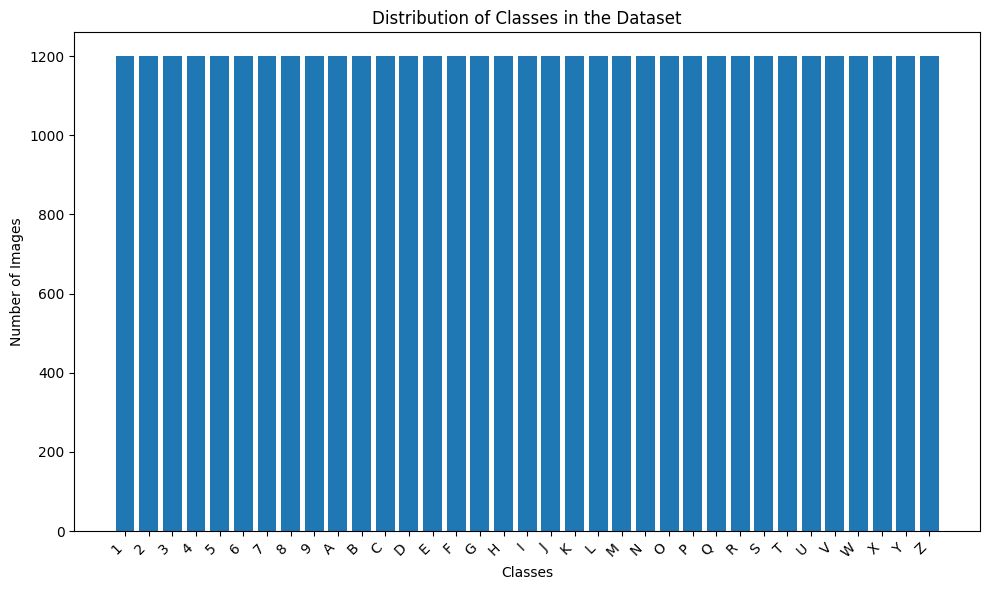

In [ ]:
# prompt: barplot the classes in order

import matplotlib.pyplot as plt
from collections import Counter

# Count the occurrences of each class
class_counts = Counter(labels)

# Sort the classes alphabetically
sorted_classes = sorted(class_counts.keys())

# Extract the counts for the sorted classes
sorted_counts = [class_counts[cls] for cls in sorted_classes]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(sorted_classes, sorted_counts)
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Distribution of Classes in the Dataset')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


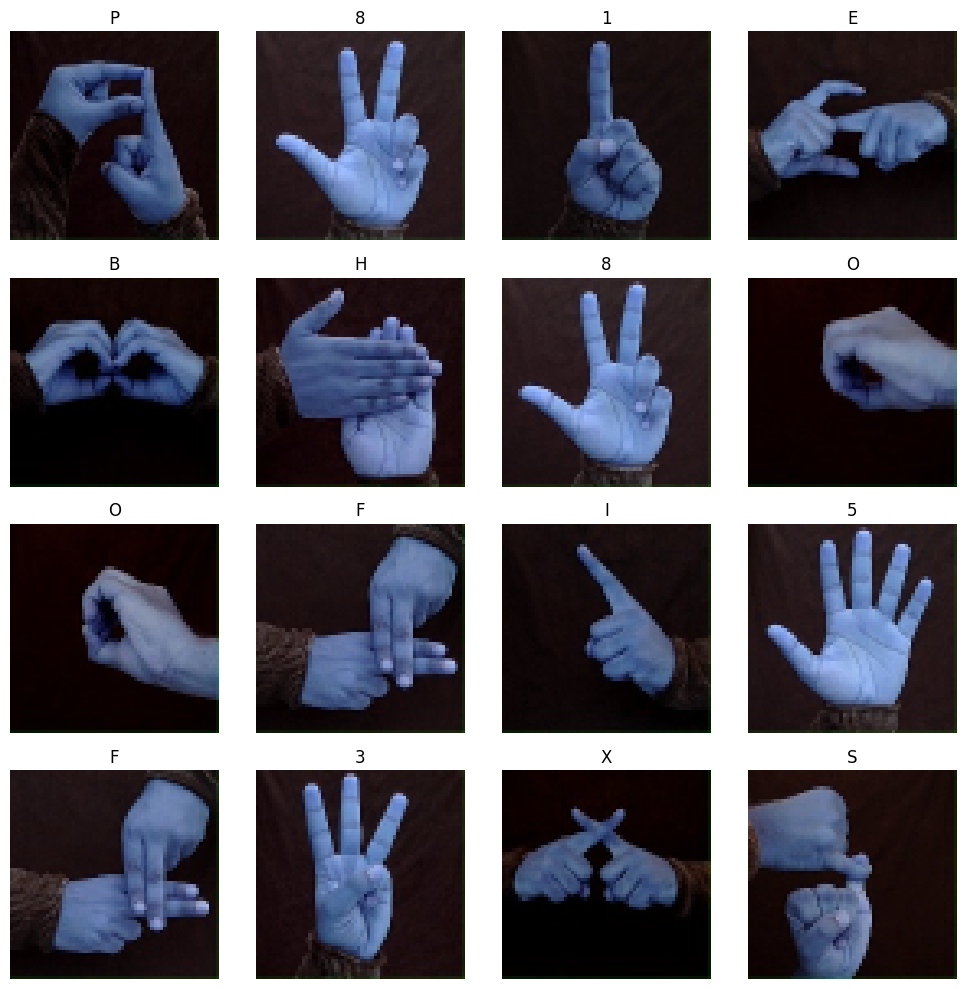

In [ ]:
# prompt: plot 4x4 samples

# Select a random subset of images for display
num_samples = 16
random_indices = np.random.choice(len(images), num_samples, replace=False)
sample_images = images[random_indices]
sample_labels = labels[random_indices]

# Display the selected images in a grid
plt.figure(figsize=(10, 10))
for i in range(num_samples):
  plt.subplot(4, 4, i + 1)
  plt.imshow(sample_images[i])
  plt.title(sample_labels[i])
  plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
# prompt: encode the labels into number

from sklearn.preprocessing import LabelEncoder

# Initialize a LabelEncoder object
label_encoder = LabelEncoder()

# Fit the encoder to the labels and transform them into numerical values
labels_encoded = label_encoder.fit_transform(labels)

# Print the encoded labels
print("Encoded labels:", labels_encoded)


Encoded labels: [ 9  9  9 ... 26 26 26]


In [ ]:
# prompt: split the data into train and test

from sklearn.model_selection import train_test_split

# Split the data into training and testing sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    images, labels_encoded, test_size=0.2, random_state=42
)

# Print the shapes of the resulting sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (33600, 64, 64, 3)
X_test shape: (8400, 64, 64, 3)
y_train shape: (33600,)
y_test shape: (8400,)


In [ ]:
# prompt: apply all kinds of augmentation on the training dataset

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator object with various augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=45,  # Randomly rotate images within 20 degrees
    width_shift_range=0.5,  # Randomly shift images horizontally by 10%
    height_shift_range=0.5,  # Randomly shift images vertically by 10%
    shear_range=0.5,  # Apply shearing transformations
    zoom_range=0.5,  # Randomly zoom into images
    horizontal_flip=True,  # Randomly flip images horizontally
    brightness_range=[0.8, 1.2], # Adjust brightness randomly
    fill_mode='nearest'  # Fill in newly created pixels with the nearest value
)


# Apply the augmentations to the training data
augmented_images = []
augmented_labels = []

for image, label in zip(X_train, y_train):
  # Generate augmented versions of the image
  for batch in datagen.flow(np.expand_dims(image, axis=0), batch_size=1):
    augmented_images.append(batch[0].astype('uint8'))
    augmented_labels.append(label)
    break  # Only generate one augmented image per original image

# Convert the augmented lists to NumPy arrays
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

# Concatenate the original and augmented training data
X_train_augmented = np.concatenate((X_train, augmented_images), axis=0)
y_train_augmented = np.concatenate((y_train, augmented_labels), axis=0)


# Print the shapes of the augmented data
print("X_train_augmented shape:", X_train_augmented.shape)
print("y_train_augmented shape:", y_train_augmented.shape)




X_train_augmented shape: (134400, 64, 64, 3)
y_train_augmented shape: (134400,)


In [ ]:
X_train = X_train_augmented
y_train = y_train_augmented

In [ ]:
# prompt: create a cnn model to predict and calculate accuracy

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define the CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))  # Output layer with number of classes

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))  # Adjust epochs as needed

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print("Test loss:", loss)
print("Test accuracy:", accuracy)


Epoch 1/10
4200/4200 ━━━━━━━━━━━━━━━━━━━━ 682s 162ms/step - accuracy: 0.6719 - loss: 1.6175 - val_accuracy: 1.0000 - val_loss: 1.1318e-04
Epoch 2/10
4200/4200 ━━━━━━━━━━━━━━━━━━━━ 672s 160ms/step - accuracy: 0.9027 - loss: 0.3014 - val_accuracy: 0.9996 - val_loss: 0.0020
Epoch 3/10
4200/4200 ━━━━━━━━━━━━━━━━━━━━ 669s 159ms/step - accuracy: 0.9357 - loss: 0.2022 - val_accuracy: 0.9999 - val_loss: 4.6538e-04
Epoch 4/10
4200/4200 ━━━━━━━━━━━━━━━━━━━━ 698s 163ms/step - accuracy: 0.9473 - loss: 0.1671 - val_accuracy: 1.0000 - val_loss: 2.7266e-05
Epoch 5/10
4200/4200 ━━━━━━━━━━━━━━━━━━━━ 729s 160ms/step - accuracy: 0.9534 - loss: 0.1561 - val_accuracy: 0.9999 - val_loss: 3.2929e-04
Epoch 6/10
4200/4200 ━━━━━━━━━━━━━━━━━━━━ 685s 161ms/step - accuracy: 0.9618 - loss: 0.1293 - val_accuracy: 0.9996 - val_loss: 0.0027
Epoch 7/10
4200/4200 ━━━━━━━━━━━━━━━━━━━━ 672s 158ms/step - accuracy: 0.9632 - loss: 0.1331 - val_accuracy: 0.9999 - val_loss: 2.9822e-04
Epoch 8/10
4200/4200 ━━━━━━━━━━━━━━━━━━━━ 

263/263 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step


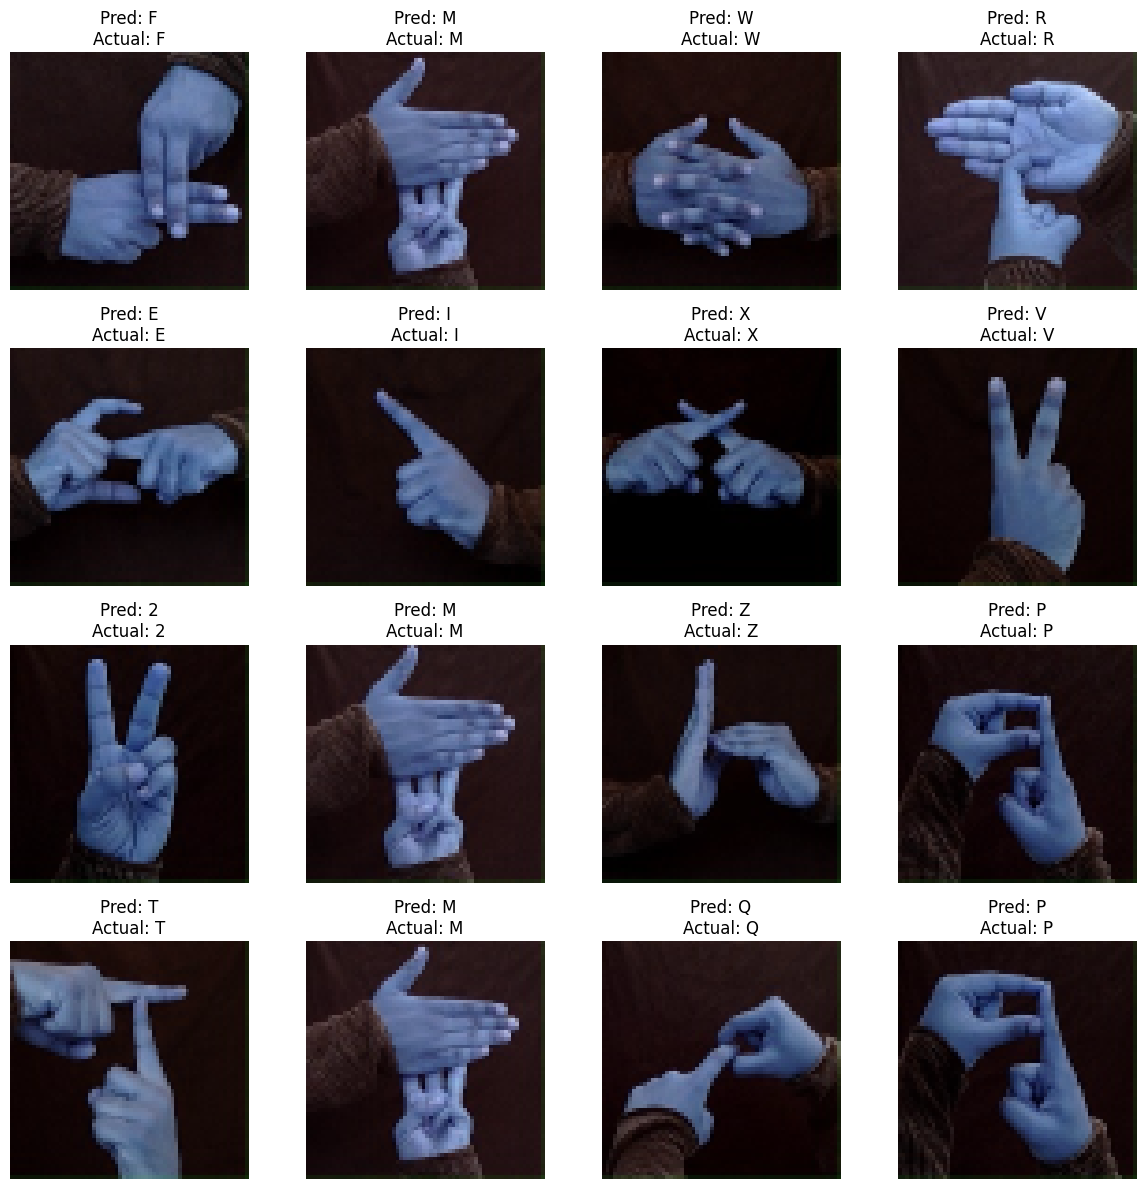

In [ ]:
# prompt: plot same samples with the prediction and the actual class plot 16 images ( 4x4 )

import matplotlib.pyplot as plt

# Predict labels for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Select 16 random samples from the test set
num_samples = 16
sample_indices = np.random.choice(X_test.shape[0], num_samples, replace=False)

# Create a 4x4 grid for plotting
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

# Plot the samples with predictions and actual labels
for i, idx in enumerate(sample_indices):
  row = i // 4
  col = i % 4
  ax = axes[row, col]
  ax.imshow(X_test[idx])
  ax.set_title(f"Pred: {label_encoder.classes_[y_pred_classes[idx]]}\nActual: {label_encoder.classes_[y_test[idx]]}")
  ax.axis('off')

plt.tight_layout()
plt.show()


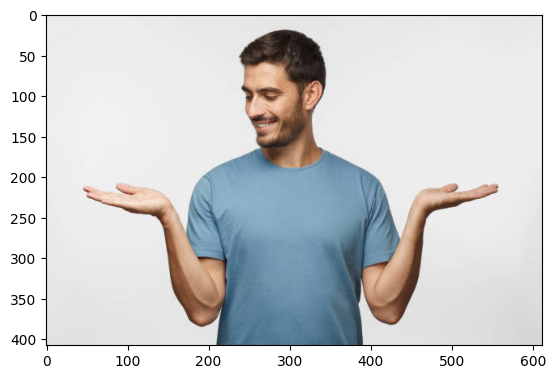

In [ ]:
# prompt: read hd.jpg
import cv2
import matplotlib.pyplot as plt
image = cv2.imread('/content/hd.jpg')
if image is not None:
  # You can now work with the image, e.g., display it
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  plt.show()
else:
  print("Error: Could not read the image file.")


In [ ]:
pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.9/35.9 MB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 22.9 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.15.0 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.5 which is incompatible.


/usr/local/lib/python3.10/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


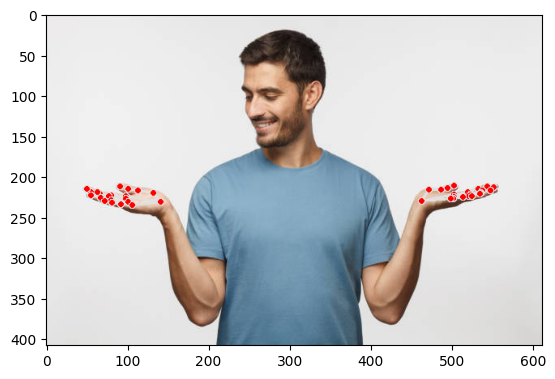

In [ ]:
# prompt: detect the hands

import cv2
import mediapipe as mp

mp_hands = mp.solutions.hands
hands = mp_hands.Hands()
mp_drawing = mp.solutions.drawing_utils

image = cv2.imread('/content/hd.jpg')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
results = hands.process(image_rgb)

if results.multi_hand_landmarks:
  for hand_landmarks in results.multi_hand_landmarks:
    mp_drawing.draw_landmarks(
        image, hand_landmarks, mp_hands.HAND_CONNECTIONS)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()


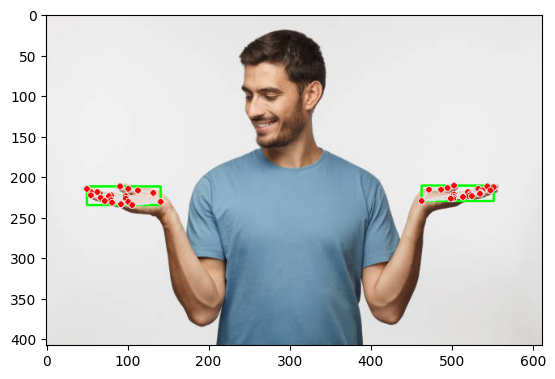

In [ ]:
# prompt: draw box in the hands

mp_hands = mp.solutions.hands
hands = mp_hands.Hands()
mp_drawing = mp.solutions.drawing_utils

image = cv2.imread('/content/hd.jpg')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
results = hands.process(image_rgb)

if results.multi_hand_landmarks:
  for hand_landmarks in results.multi_hand_landmarks:
    # Get the bounding box coordinates
    x_coords = [landmark.x for landmark in hand_landmarks.landmark]
    y_coords = [landmark.y for landmark in hand_landmarks.landmark]
    x_min = int(min(x_coords) * image.shape[1])
    y_min = int(min(y_coords) * image.shape[0])
    x_max = int(max(x_coords) * image.shape[1])
    y_max = int(max(y_coords) * image.shape[0])

    # Draw a rectangle around the hand
    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

    mp_drawing.draw_landmarks(
        image, hand_landmarks, mp_hands.HAND_CONNECTIONS)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()


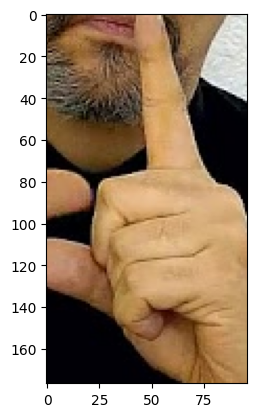

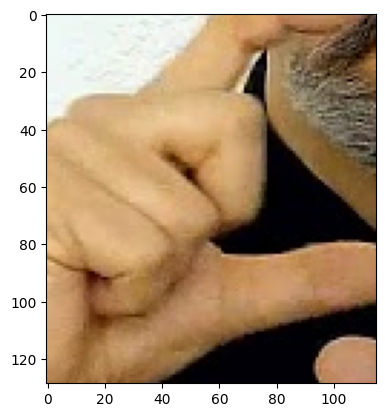

In [ ]:
# prompt: get the sub images that contain the hands and dont draw any dots or squars in them

import cv2
import matplotlib.pyplot as plt
import mediapipe as mp

mp_hands = mp.solutions.hands
hands = mp_hands.Hands()
mp_drawing = mp.solutions.drawing_utils

image = cv2.imread('/content/hd1.jpg')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
results = hands.process(image_rgb)

subImgs = []

if results.multi_hand_landmarks:
  for hand_landmarks in results.multi_hand_landmarks:
    # Get the bounding box coordinates
    x_coords = [landmark.x for landmark in hand_landmarks.landmark]
    y_coords = [landmark.y for landmark in hand_landmarks.landmark]
    x_min = int(min(x_coords) * image.shape[1])
    y_min = int(min(y_coords) * image.shape[0])
    x_max = int(max(x_coords) * image.shape[1])
    y_max = int(max(y_coords) * image.shape[0])

    # Extract the sub-image containing the hand
    hand_image = image[y_min:y_max, x_min:x_max]

    subImgs.append(hand_image)

    # Display the extracted hand image
    plt.imshow(cv2.cvtColor(hand_image, cv2.COLOR_BGR2RGB))
    plt.show()


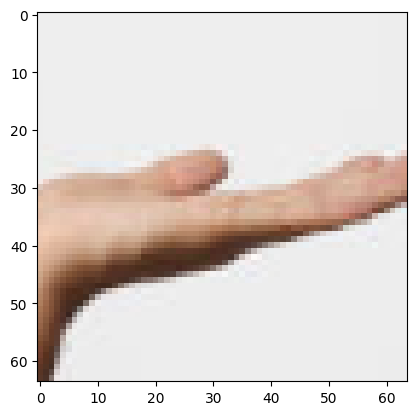

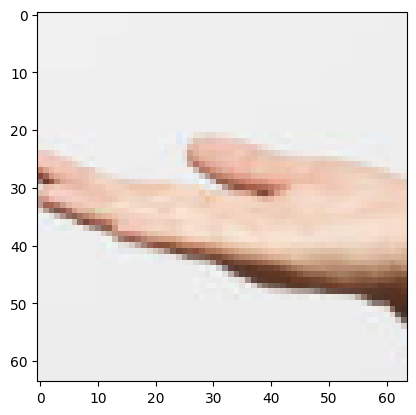

In [ ]:
# prompt: get the sub images that contain the hands and the sub images should be squared images

mp_hands = mp.solutions.hands
hands = mp_hands.Hands()
mp_drawing = mp.solutions.drawing_utils

image = cv2.imread('/content/hd.jpg')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
results = hands.process(image_rgb)

subImgs = []

if results.multi_hand_landmarks:
  for hand_landmarks in results.multi_hand_landmarks:
    # Get the bounding box coordinates
    x_coords = [landmark.x for landmark in hand_landmarks.landmark]
    y_coords = [landmark.y for landmark in hand_landmarks.landmark]
    x_min = int(min(x_coords) * image.shape[1])
    y_min = int(min(y_coords) * image.shape[0])
    x_max = int(max(x_coords) * image.shape[1])
    y_max = int(max(y_coords) * image.shape[0])

    # Calculate the side length for a square sub-image
    side_length = max(x_max - x_min, y_max - y_min)

    # Calculate the center of the bounding box
    center_x = (x_min + x_max) // 2
    center_y = (y_min + y_max) // 2

    # Calculate the top-left corner of the square sub-image
    new_x_min = max(0, center_x - side_length // 2)
    new_y_min = max(0, center_y - side_length // 2)
    new_x_max = min(image.shape[1], center_x + side_length // 2)
    new_y_max = min(image.shape[0], center_y + side_length // 2)


    # Extract the square sub-image containing the hand
    hand_image = image[new_y_min:new_y_max, new_x_min:new_x_max]

    # Resize the sub-image to a fixed size (if necessary)
    hand_image = cv2.resize(hand_image, (64, 64))


    subImgs.append(hand_image)

    # Display the extracted hand image
    plt.imshow(cv2.cvtColor(hand_image, cv2.COLOR_BGR2RGB))
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


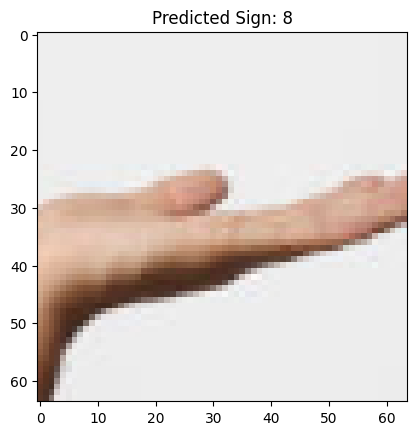

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


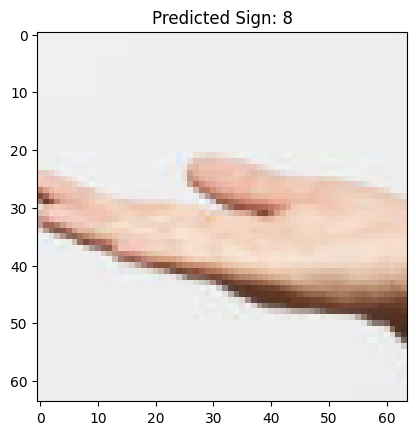

In [ ]:
# prompt: feed the images to the model and predict the sign language and print the image

if subImgs:
  for hand_image in subImgs:
    # Preprocess the image (resize, normalize, etc.)
    img = cv2.resize(hand_image, (64, 64))
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Make a prediction
    prediction = model.predict(img)
    predicted_class = np.argmax(prediction)

    # Get the predicted label
    predicted_label = label_encoder.classes_[predicted_class]

    # Display the image with the prediction
    plt.imshow(cv2.cvtColor(hand_image, cv2.COLOR_BGR2RGB))
    plt.title(f"Predicted Sign: {predicted_label}")
    plt.show()
else:
  print("No hands detected in the image.")
